In [6]:
%load_ext autoreload

%autoreload 2

In [7]:
import numpy as np

# Steps

- Train loop
    - Forward
        - Conv
        - Relu
        - Conv
        - Relu
        - Dense
        - Softmax
        - Cross entropy
    
    Backprop the gradients for all the layers

    Test the code for MNIST

In [11]:
import mnist

In [12]:
mnist.init()

Download complete.
Save complete.


In [13]:
x_train, y_train, x_test, y_test = mnist.load()

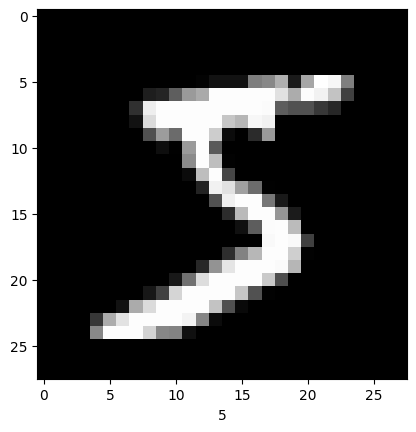

In [14]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [15]:
from layer import Layer

In [16]:
class ReluLayer(Layer):
    def __init__(self, layer_name):
        super().__init__(layer_name)
        self.cached_output = None

    def forward(self, input_activations):
        self.cached_output = np.maximum(0, input_activations)
        return self.cached_output

    def backward(self, global_gradients, lr):
        local_grad = np.array(global_gradients, copy=True)
        local_grad[self.cached_output <= 0] = 0 
        return local_grad

In [17]:
class DenseLayer(Layer):
    def __init__(self, layer_name, input_nodes, output_nodes, debug = False):
        super().__init__(layer_name)
        self.debug = debug
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        '''
        Gloro/Xavier initialization for weights for faster convergence
        https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
        '''
        limit = np.sqrt(2 / float(input_nodes + output_nodes))
        # Glorot/Xavier init lead to faster convergence
        # self.weights = np.random.normal(0.0, limit, size = (input_nodes, output_nodes))
        self.weights = np.random.randn(input_nodes, output_nodes)

        ''' 
        No initialization is required for bias,
        https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases
        '''
        self.bias = np.zeros(output_nodes)

        #we need to cache the input and output from this layer for the purpose of backprop
        self.cached_input = None
        self.cached_output = None

    # overriden
    def forward(self, input_activations):
        '''

        @param input_activations - Output of previous layer
        @return softmax of logits

        Dense layer forward prop
        1. Flatten the input
        2. Dot product with weights and add the bias
        3. Cache the input and logits for backpop
        4. Apply softmax on logits and return it
        '''

        shape = input_activations.shape
        layer_input = input_activations.ravel().reshape(shape[0], -1)
        layer_logits = np.dot(layer_input, self.weights) + self.bias

        self.cached_input = layer_input
        self.cached_output = layer_logits
        if self.debug:
            print(f"Cached output {self.cached_output}, ip shape {layer_input.shape}, op shape {layer_logits.shape}")
        return self.cached_output


    #overriden
    def backward(self, global_gradient, current_lr):
        '''
        @param global_gradient, gradients from the previous layer
        @param current_lr 


        @returns The gradient of Loss w.r.t to the input to this layer
        i.e the input_activations recieved during forward pass.

        Dense layer backward prop
        1. Calculate the gradients w.r.t to the weights
        2. Calculate the gradients w.r.t to the received activations
        and return it for usage in other previous layers.

        '''
        output_grad  = global_gradient
        

        assert output_grad.shape[1] == self.weights.T.shape[0]
        assert self.cached_input.T.shape[1] == output_grad.shape[0]

        input_grad = np.dot(output_grad, self.weights.T)
        weight_grad = np.dot(self.cached_input.T, output_grad)
        
        if self.debug:
            print(f"weights shape {self.weights.shape}, weight grad shape {weight_grad.shape}, input_shape {self.cached_input.shape}, input_grad shape {input_grad.shape}, ")

        self.weights -= current_lr * weight_grad
        self.bias -= current_lr * np.sum(output_grad, axis=1)

        return input_grad
    



In [18]:
dense_1 = DenseLayer("Dense_1",784, 10)

In [335]:
dense_1.forward(np.random.randn(1,784)).shape

(1, 10)

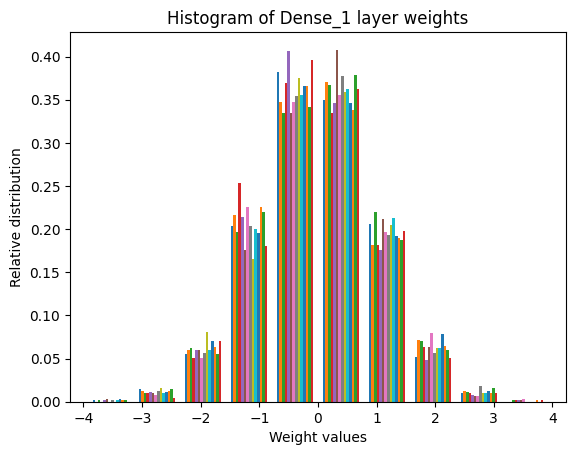

In [23]:
import utils
utils.plot_histogram(dense_1.layer_name, dense_1.weights)

In [24]:
28*28

784

### Model

In [25]:
from activations import Softmax_Categorical_CrossEntropy

In [26]:
dense_1 = DenseLayer("Dense_1", 784, 14)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

softmax_loss = Softmax_Categorical_CrossEntropy("Softmax_CCE_1")

In [340]:
y = dense_1.forward(img1.reshape(1, 28, 28))
relu_y = relu_1.forward(y)
y = dense_2.forward(relu_y)

true_labels = y_train[0].reshape(1,1)
loss = softmax_loss.forward(y, true_labels)
print(f"loss {loss}, ypredicted {y}")

# gradients /= samples

global_grad = softmax_loss.backward(softmax_loss.cached_output, true_labels)
print(global_grad.shape)

global_grad = dense_2.backward(global_grad, 1e-6)
print(global_grad.shape)
global_grad = relu_1.backward(global_grad, 1e-6)


loss [[16.11809565]], ypredicted [[ 1212.10167608 -4452.17893816 -3279.38222992  6058.23590186
  -2703.8253442   4036.29283364  6565.74291801 -7483.58342666
   -609.16505943  9183.59830442]]
(1, 10)
(1, 14)


In [ ]:
global_grad = dense_1.backward(global_grad, 1e-06)

In [341]:
relu_y

array([[1215.48713053,    0.        , 2780.3713942 , 1405.36635969,
        3073.09237029,    0.        ,  506.11097248,    0.        ,
         279.45999496, 1412.14358177,    0.        , 1315.95382637,
        1387.30896807,    0.        ]])

In [342]:
relu_y <= 0

array([[False,  True, False, False, False,  True, False,  True, False,
        False,  True, False, False,  True]])

In [344]:
# global_grad[relu_y <= 0] = 0

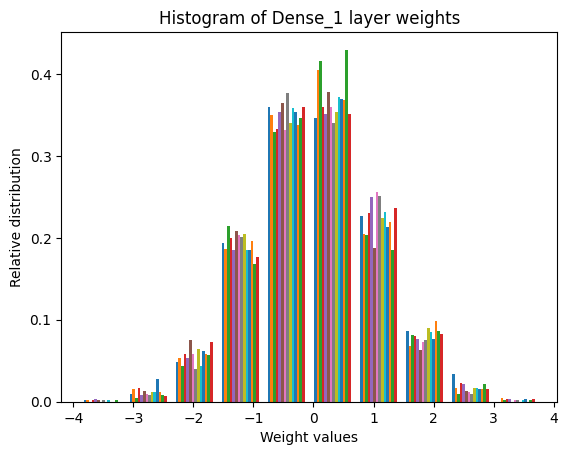

In [346]:
utils.plot_histogram("Dense_1", dense_1.weights)

### Sequential

In [27]:
from model import Sequential

np.random.seed(42)

dense_1 = DenseLayer("Dense_1", 784, 14)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

layers = [dense_1, relu_1, dense_2]
sequential_model = Sequential(layers)

In [28]:
x_train.shape

(60000, 784)

In [29]:
x_preprocessed = x_train[:4000]
y_preprocessed = y_train[:4000]

x_preprocessed = utils.minmax_normalize(x_preprocessed)

In [30]:
x_val_preprocessed = x_train[4000: 6000]
y_val_preprocessed = y_train[4000: 6000]

x_val_preprocessed = utils.minmax_normalize(x_val_preprocessed)

In [351]:
y_val_preprocessed

array([7, 3, 0, ..., 8, 6, 9], dtype=uint8)

In [352]:
sequential_model.train([x_preprocessed, y_preprocessed], [x_val_preprocessed, y_val_preprocessed], 20, 1, True)

----------
Epoch 1, Time 3.0976808071136475 seconds
Train Accuracy 37.25, Validation accuracy 45.6
Train Loss [6839.52598954], Validation loss [1.56211754]
----------
----------
Epoch 2, Time 3.1066136360168457 seconds
Train Accuracy 53.7, Validation accuracy 57.49999999999999
Train Loss [5259.5557056], Validation loss [1.26554238]
----------
----------
Epoch 3, Time 2.960618734359741 seconds
Train Accuracy 59.975, Validation accuracy 61.4
Train Loss [4472.03797565], Validation loss [1.17037162]
----------
----------
Epoch 4, Time 3.04988169670105 seconds
Train Accuracy 65.875, Validation accuracy 65.64999999999999
Train Loss [3886.46683554], Validation loss [1.08777959]
----------
----------
Epoch 5, Time 3.326667070388794 seconds
Train Accuracy 70.6, Validation accuracy 71.15
Train Loss [3462.31075629], Validation loss [0.97508617]
----------
----------
Epoch 6, Time 2.887345552444458 seconds
Train Accuracy 72.275, Validation accuracy 70.95
Train Loss [3210.14962532], Validation loss

In [31]:
x_test_preprocessed = x_test
y_test_preprocessed = y_test

x_test_preprocessed = utils.minmax_normalize(x_test_preprocessed)

In [354]:
sequential_model.test([x_test_preprocessed, y_test_preprocessed])

(81.42, array([0.73575979]))

In [356]:
x_train.shape

(60000, 784)

In [32]:
permuted_idx = np.random.permutation(range(x_train.shape[0]))
x_permuted = x_train[permuted_idx]
y_permuted = y_train[permuted_idx]

2

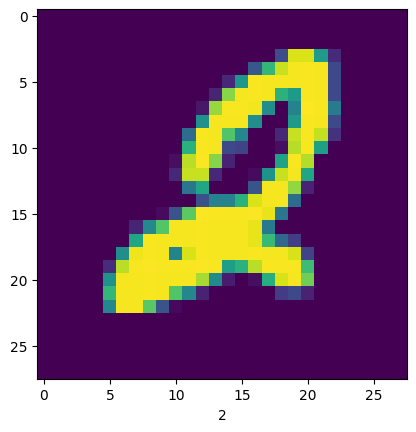

In [363]:
idx = np.random.randint(0,10000)
test_image = utils.minmax_normalize(x_permuted[idx])

plt.imshow(test_image.reshape(28, 28))
plt.xlabel(y_permuted[idx])

np.argmax(sequential_model._forward(np.expand_dims(test_image, 0)))

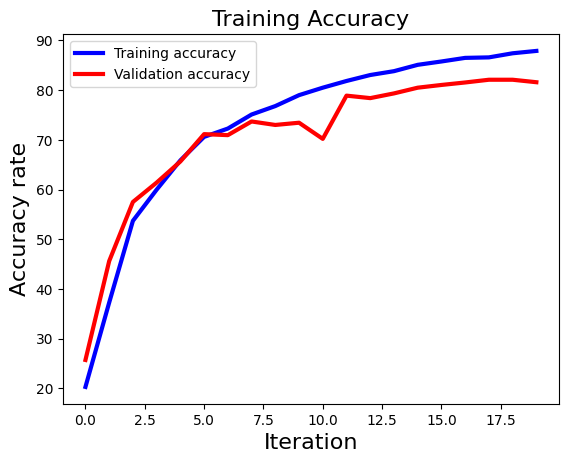

In [364]:
utils.plot_accuracy_curve(sequential_model.train_accuracy, sequential_model.validation_accuracy)

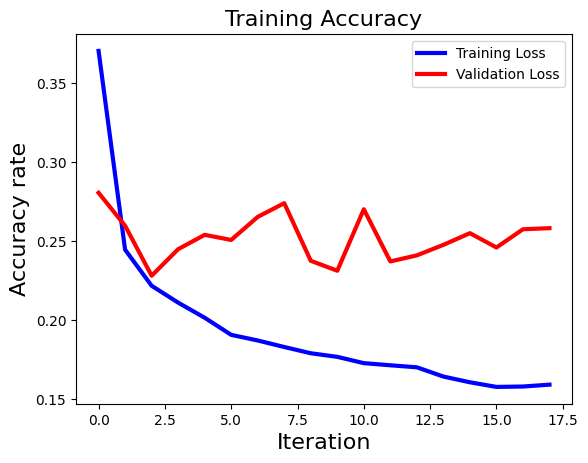

In [329]:
utils.plot_loss_curve(sequential_model.train_loss, sequential_model.validation_loss)

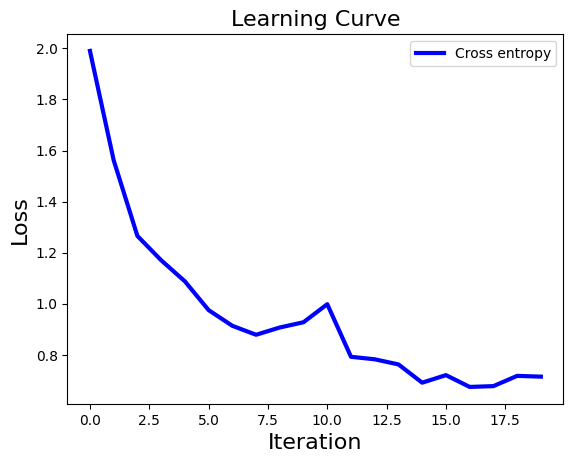

In [365]:
utils.plot_learning_curve(sequential_model.validation_loss)

# Conv layer

In [33]:
import numpy as np
from layer import Layer

In [688]:
class ConvLayer(Layer):
    def __init__(self, layer_name, n_filters = 8, filter_size = 3, stride = 1, debug = True):
        super().__init__(layer_name)
        np.random.seed(42)
                
        self.filter_size = filter_size
        self.stride = stride
        self.n_filters = n_filters

        self.cached_input = None
        self.debug = debug
        self.cached_input_activations = None
        self.cached_output_activations = None

    def get_patch(self, image, width_idx, height_idx, filter_size):
        return image[:, :, height_idx:height_idx+filter_size, width_idx: width_idx+filter_size]

    def forward(self, input_activations):
        '''
        @param input_activations - output of previous layer, will be of shape
        N x C x H x W 
        Conv forward

        1. Get the patch of the size similar to conv filter
        2. Perform convolution on that patch and store in an numpy array
        3. Do the above for all the filters
        4. Append all the filters output and return it for next layer

        '''
        first_activation = True
        n_samples, input_channels, input_width, input_height = input_activations.shape

        if self.debug:
            print(f"{n_samples=}, {input_channels=}, {input_width=}, {input_height=}")
            
        self.conv_filter = np.random.randn(self.n_filters, input_channels, self.filter_size, self.filter_size) * 0.1

        output_shape = ((input_width - self.filter_size) // self.stride) + 1 
        output_activations = np.zeros([])
        self.cached_input_activations = input_activations

        for conv_filter in self.conv_filter:
            filter_output = np.zeros((n_samples, output_shape, output_shape))
            width_idx, height_idx = 0, 0
            
            while (height_idx + self.filter_size) <= input_height:
                width_idx = 0
                while (width_idx + self.filter_size) <= input_width:
                    patch = self.get_patch(input_activations, width_idx, height_idx, self.filter_size)
                  
                
                    # if self.debug:
                    #     print(f"{col_idx=}, {row_idx=}, {patch.shape=}, {conv_filter.shape=}")
                    conv = np.sum(conv_filter * patch, axis=(1,2,3))
                    if first_activation:
                        print(f"{filter_output.shape=}, {patch.shape=}, {conv.shape=}")
                    filter_output[:, height_idx, width_idx] = conv
                    
                    width_idx += 1
                    
                height_idx += 1
                # filter_output = filter_output.reshape(output_shape, output_shape)
            
            if first_activation:
                output_activations = filter_output
                output_activations = np.expand_dims(output_activations, axis=1)
                first_activation = False

            else:
                filter_output = np.expand_dims(filter_output, axis=1)
                print(f"{output_activations.shape=}, {filter_output.shape=}")
                output_activations = np.append(output_activations, filter_output, axis=1)

            if self.debug:
                print(f"{output_activations.shape=}, {filter_output.shape=}")

        self.cached_output_activations = output_activations
        return output_activations

    def backward(self):
        pass

In [689]:
t = np.random.randn(2, 3, 3, 3)

In [690]:
t = np.array([
    [
        [
            [1,2,3], [1,2,3]
            ],
            [
            [1,2,3], [1,2,3]
            ]
        ], 
    [
        [
            [1,2,3], [1,2,3]
            ],
            [
            [1,2,3], [1,2,3]
            ]
        ]
             ])

print(t.shape)

(2, 2, 2, 3)


In [691]:
s = t.sum(axis=(1,2,3))

In [692]:
s.shape

(2,)

In [693]:
t

array([[[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]],


       [[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]]])

In [694]:
s

array([24, 24])

In [695]:
img1.shape

(2, 1, 28, 28)

In [696]:
conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 1)

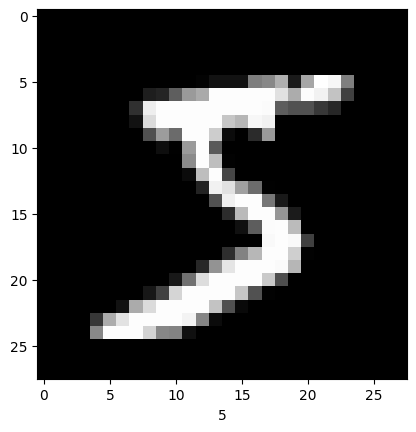

In [697]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [698]:
img1 = np.expand_dims(img1, axis=0)
img1 = np.expand_dims(img1, axis=0)

In [699]:
img1.shape

(1, 1, 28, 28)

In [700]:
conv1_activations = conv_1.forward(img1)

conv1_activations.shape

n_samples=1, input_channels=1, input_width=28, input_height=28
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
filter_output.shape=(1, 26, 26), patc

(1, 8, 26, 26)

In [701]:
conv1_activations[0].shape

(8, 26, 26)

In [702]:
conv1_activations.shape

(1, 8, 26, 26)

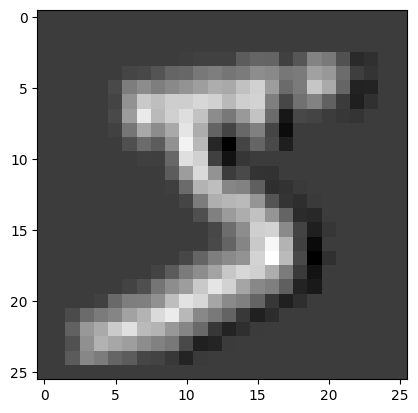

In [703]:
h = conv1_activations.shape[1]
w = conv1_activations.shape[2]
plt.imshow(conv1_activations[0][7], cmap="gray")

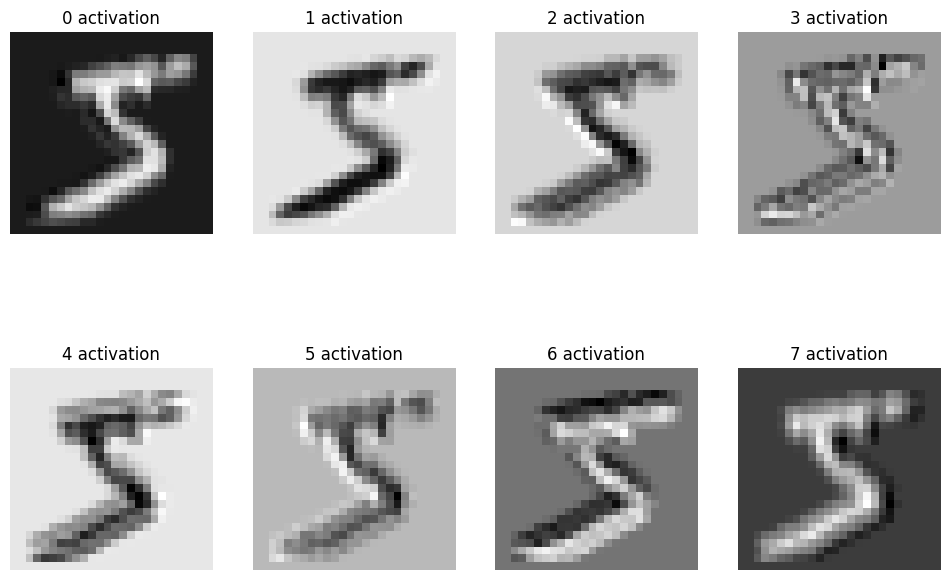

In [704]:
utils.visualize_filters(conv1_activations, 2,4)

# Multiple convolutions

In [705]:
from typing import List

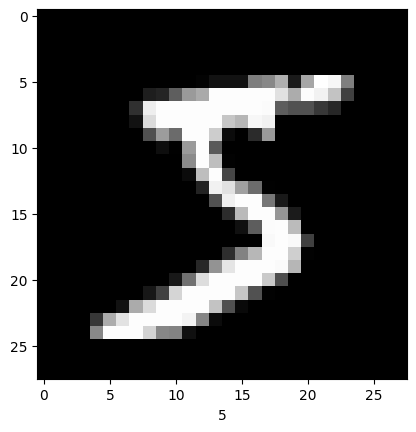

In [724]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [728]:
img1 = np.expand_dims(img1, axis=0)
img1 = np.expand_dims(img1, axis=0)

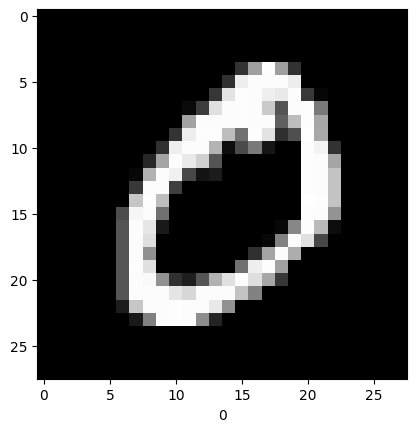

In [725]:
import matplotlib.pyplot as plt

img2 = x_train[1,:].reshape(28,28) # First image in the training set.
plt.imshow(img2,cmap='gray')
plt.xlabel(y_train[1])
plt.show() # Show the image

In [726]:
img2 = np.expand_dims(img2, axis=0)
img2 = np.expand_dims(img2, axis=0)

In [729]:
img1.shape

(1, 1, 28, 28)

In [730]:
img2.shape

(1, 1, 28, 28)

In [731]:
img_data = np.vstack((img1, img2))

print(img_data.shape)

(2, 1, 28, 28)


In [749]:
conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 1)
relu_1 = ReluLayer("relu_1")
conv_2 = ConvLayer("conv_2", n_filters = 10, filter_size = 3, stride = 1)
relu_2 = ReluLayer("relu_2")

conv_block: List[Layer] = [conv_1, relu_1, conv_2, relu_2]

output_activations = img_data

for layer in conv_block:
    output_activations = layer.forward(output_activations)

n_samples=2, input_channels=1, input_width=28, input_height=28
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
filter_output.shape=(2, 26, 26), patc

In [750]:
conv_1.conv_filter.shape

(8, 1, 3, 3)

In [751]:
conv_2.conv_filter.shape

(10, 8, 3, 3)

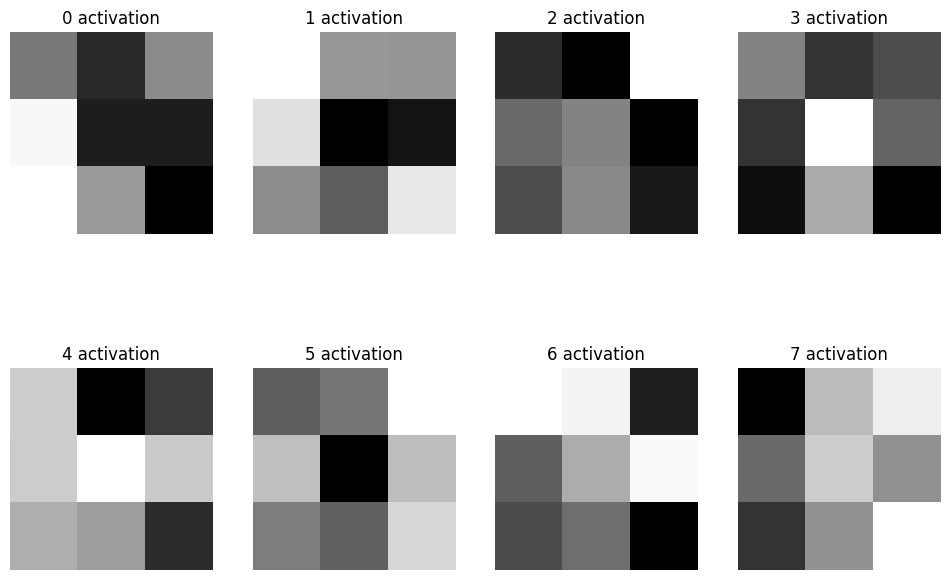

In [752]:
utils.visualize_filters(conv_1.conv_filter, 2, 4)

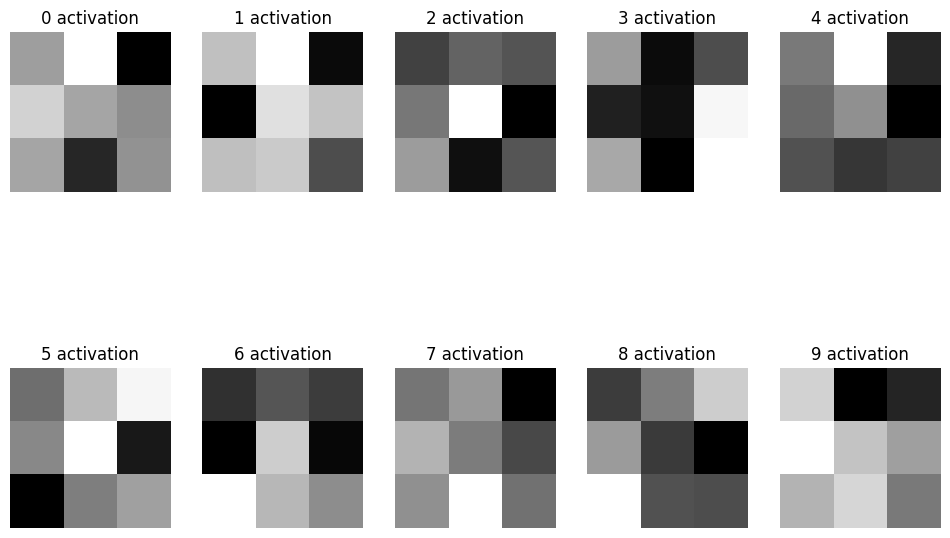

In [753]:
utils.visualize_filters(conv_2.conv_filter, 2, 5)

In [754]:
conv_1.cached_output_activations.shape

(2, 8, 26, 26)

In [757]:
# def visualize_activations(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
#     for i, ax in enumerate(axes.flat):
#         img = images[i]
#         ax.imshow(img, cmap="gray")
#         ax.set_title(f"{i} activation")
#         ax.axis("off")
#     plt.show()


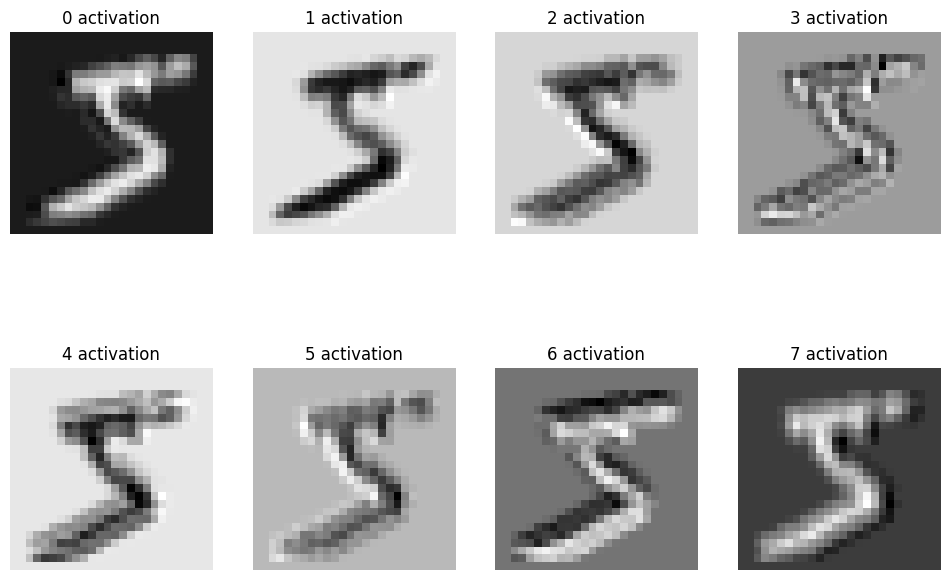

In [758]:
utils.visualize_activations(conv_1.cached_output_activations[0], 2, 4)

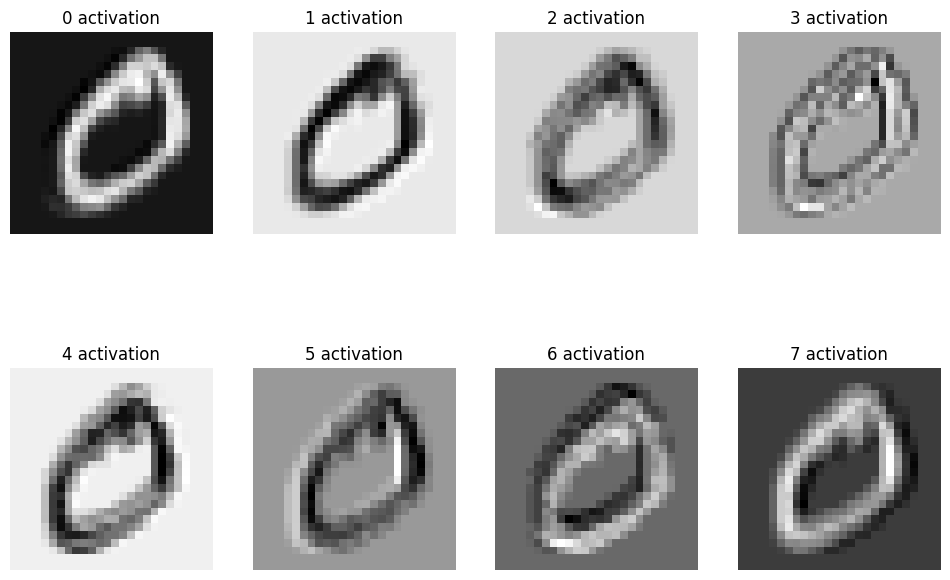

In [759]:
utils.visualize_activations(conv_1.cached_output_activations[1], 2, 4)

In [760]:
conv_2.cached_output_activations.shape

(2, 10, 24, 24)

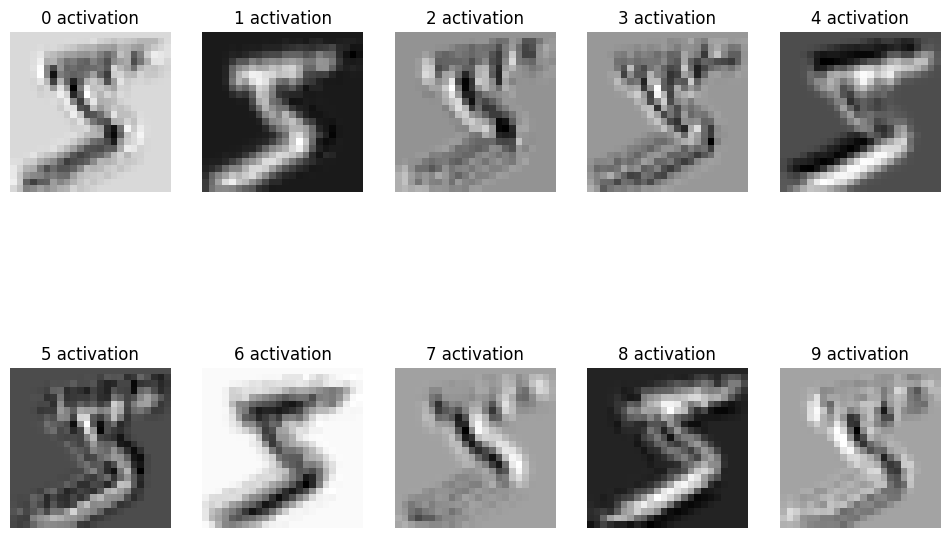

In [763]:
utils.visualize_activations(conv_2.cached_output_activations[0], 2, 5)

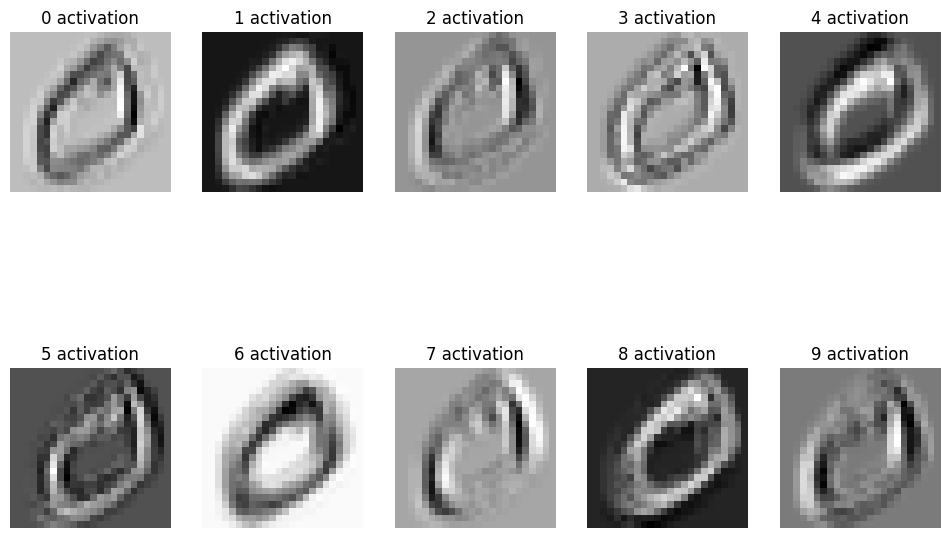

In [764]:
utils.visualize_activations(conv_2.cached_output_activations[1], 2, 5)